In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
%ls

README.md                       jobs/
__pycache__/                    low-dimension-search-results/
algorithm_compare_results/      models/
data-queue/                     paper-images/
deeplifting/                    requirements.txt
deeplifting.png                 results/
high-dimension-paper-results/   search_results/
high-dimension-search-results/  tasks.py
images/                         test-low-dimension-results.png


In [4]:
import glob as glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

# High Dimensional Deeplifting Results

The final data will be in the `data-queue/high-dimensional-deeplifting`. We will need to continue to extract the information from MSI.

In [5]:
columns = [
    'f',
    'algorithm',
    'total_time',
    'input_size',
    'hidden_size',
    'hidden_activation',
    'output_activation',
    'agg_function',
    'include_bn',
    'problem_name',
    'global_minimum',
    'dimensions',
]

# Bring in the deeplifting results
dl_file_directory = './data-queue/high-dimensional-deeplifting/*/*'
dl_files = glob.glob(dl_file_directory)

deeplifting_data_list = []
for file in tqdm.tqdm(dl_files):
    df = pd.read_parquet(file)
    df = df[columns]
    df['hits'] = np.abs(df['f'] - df['global_minimum']) <= 1e-4
    deeplifting_data_list.append(df)

deeplifting_df = pd.concat(deeplifting_data_list)
del deeplifting_data_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 17.78it/s]


In [6]:
deeplifting_df.head()

,f,algorithm,total_time,input_size,hidden_size,hidden_activation,output_activation,agg_function,include_bn,problem_name,global_minimum,dimensions,hits
0,1.150094e-13,Deeplifting,1.436128,512,128-128,sine,sine,sum,True,chung_reynolds_5d,0.0,5,True
1,7.348694e-13,Deeplifting,2.146152,512,128-128,sine,sine,sum,True,chung_reynolds_5d,0.0,5,True
2,9.069837e-16,Deeplifting,2.303905,512,128-128,sine,sine,sum,True,chung_reynolds_5d,0.0,5,True
3,5.958433e-12,Deeplifting,2.317969,512,128-128,sine,sine,sum,True,chung_reynolds_5d,0.0,5,True
4,3.284008e-16,Deeplifting,2.501872,512,128-128,sine,sine,sum,True,chung_reynolds_5d,0.0,5,True


In [7]:
# We need to get the results over all of the different configuration
# and we will report on the best results
groupby_columns = [
    'algorithm',
    'problem_name',
    'dimensions',
    'input_size',
    'hidden_activation',
    'output_activation',
    'agg_function',
    'include_bn',
]

# Final deeplifting columns
columns = ['problem_name', 'algorithm', 'dimensions', 'hits-mean', 'total_time-mean']

deeplifting_results_df = deeplifting_df.groupby(groupby_columns).agg(
    {'hits': ['count', 'mean'], 'total_time': 'mean'}
)
deeplifting_results_df.columns = [
    '-'.join(column) for column in deeplifting_results_df.columns
]
deeplifting_results_df = deeplifting_results_df.reset_index()

# Now sort by best result
deeplifting_results_df = (
    deeplifting_results_df.sort_values(
        ['problem_name', 'hits-mean'], ascending=[True, False]
    )
    .groupby(['problem_name'])
    .first()
    .reset_index()
)

# Get the final dataframe
# TODO: We still have work todo to get the final data
# but we at least want to be able to show current results
deeplifting_results_df = deeplifting_results_df[columns]
deeplifting_results_df = deeplifting_results_df.rename(
    columns={'total_time-mean': 'time-mean'}
)
deeplifting_results_df.head()

,problem_name,algorithm,dimensions,hits-mean,time-mean
0,ackley_1000d,Deeplifting,1000,1.000000,0.888520
1,ackley_100d,Deeplifting,100,0.183333,6.451093
2,ackley_30d,Deeplifting,30,0.233333,6.151020
3,ackley_3d,Deeplifting,3,0.966667,24.448457
4,ackley_500d,Deeplifting,500,0.900000,1.106324


# Algorithm Comparison Results

In [8]:
# Algorithm keep columns
algorithm_columns = [
    'problem_name',
    'algorithm',
    'dimensions',
    'hits',
    'time',
]

# Results from comparison algorithms
file_directory = './high-dimension-paper-results/*/*'
files = glob.glob(file_directory)
algorithm_df = pd.read_parquet(files)
algorithm_df = algorithm_df[algorithm_columns]
algorithm_df.head()

,problem_name,algorithm,dimensions,hits,time
0,chung_reynolds_100d,IPOPT,100,0,0.054880
1,chung_reynolds_100d,IPOPT,100,1,0.039149
2,chung_reynolds_100d,IPOPT,100,0,0.050758
3,chung_reynolds_100d,IPOPT,100,0,0.078572
4,chung_reynolds_100d,IPOPT,100,0,0.057365


In [9]:
# Let's get the algorithm compare results!
algorithm_results_df = algorithm_df.groupby(
    ['problem_name', 'algorithm', 'dimensions']
).agg({'hits': ['count', 'mean'], 'time': 'mean'})
algorithm_results_df.columns = [
    '-'.join(column) for column in algorithm_results_df.columns
]
algorithm_results_df = algorithm_results_df.reset_index()

# Need to verify that all problems have the same number of trials in the end
algorithm_results_df = algorithm_results_df.drop(columns=['hits-count'])
algorithm_results_df.head()

,problem_name,algorithm,dimensions,hits-mean,time-mean
0,ackley_1000d,Differential Evolution,1000,0.0,15.978809
1,ackley_1000d,Dual Annealing,1000,0.2,279.784676
2,ackley_1000d,IPOPT,1000,0.0,1.939134
3,ackley_1000d,PyGRANSO,1000,0.0,261.488945
4,ackley_1000d,SCIP,1000,1.0,11.479718


# Full Results
Combine the full results and let's create a facet grid.

In [10]:
results_df = pd.concat(
    [deeplifting_results_df, algorithm_results_df], axis=0, ignore_index=True
)

# Set the problem
results_df['problem'] = results_df['problem_name'].str.replace(
    r'_[0-9]+d', '', regex=True
)
results_df['problem'] = np.where(
    results_df['problem'].str.contains('reyonlds'),
    'chung_reynolds',
    results_df['problem'],
)
results_df['problem'] = np.where(
    results_df['problem'].str.contains('reynolds'),
    'Chung Reynolds',
    results_df['problem'],
)
results_df['time-mean-log'] = results_df['time-mean'].apply(np.log1p)
results_df['dimensions-log'] = results_df['dimensions'].apply(np.log1p)
results_df.head()

,problem_name,algorithm,dimensions,hits-mean,time-mean,problem,time-mean-log,dimensions-log
0,ackley_1000d,Deeplifting,1000,1.000000,0.888520,ackley,0.635794,6.908755
1,ackley_100d,Deeplifting,100,0.183333,6.451093,ackley,2.008361,4.615121
2,ackley_30d,Deeplifting,30,0.233333,6.151020,ackley,1.967255,3.433987
3,ackley_3d,Deeplifting,3,0.966667,24.448457,ackley,3.236655,1.386294
4,ackley_500d,Deeplifting,500,0.900000,1.106324,ackley,0.744944,6.216606


In [11]:
# Sanity check that all problems exists for each algorithm
results_df.groupby(['problem', 'algorithm']).size()

problem         algorithm             
Chung Reynolds  Deeplifting               6
                Differential Evolution    6
                Dual Annealing            6
                IPOPT                     6
                PyGRANSO                  6
                SCIP                      6
ackley          Deeplifting               6
                Differential Evolution    6
                Dual Annealing            6
                IPOPT                     6
                PyGRANSO                  6
                SCIP                      6
alpine1         Deeplifting               6
                Differential Evolution    4
                Dual Annealing            4
                IPOPT                     4
                PyGRANSO                  5
                SCIP                      4
griewank        Deeplifting               6
                Differential Evolution    6
                Dual Annealing            6
                IPOPT                

In [ ]:
# Create the FacetGrid
g = sns.FacetGrid(
    results_df, col="problem", col_wrap=3, sharex=True, sharey=True, height=3
)

# Map the data to the grid
g.map_dataframe(
    sns.stripplot, x='hits-mean', y='algorithm', hue='dimensions', palette='viridis'
)

# Add legends and other aesthetic improvements
g.add_legend()
g.set_axis_labels("Dimensions", "Time")
g.set_titles(col_template="{col_name} problem")

# Add grids for all axes
for ax in g.axes.flatten():
    ax.grid()

# Use matplotlib instead of seaborn because the jet colors do not exist

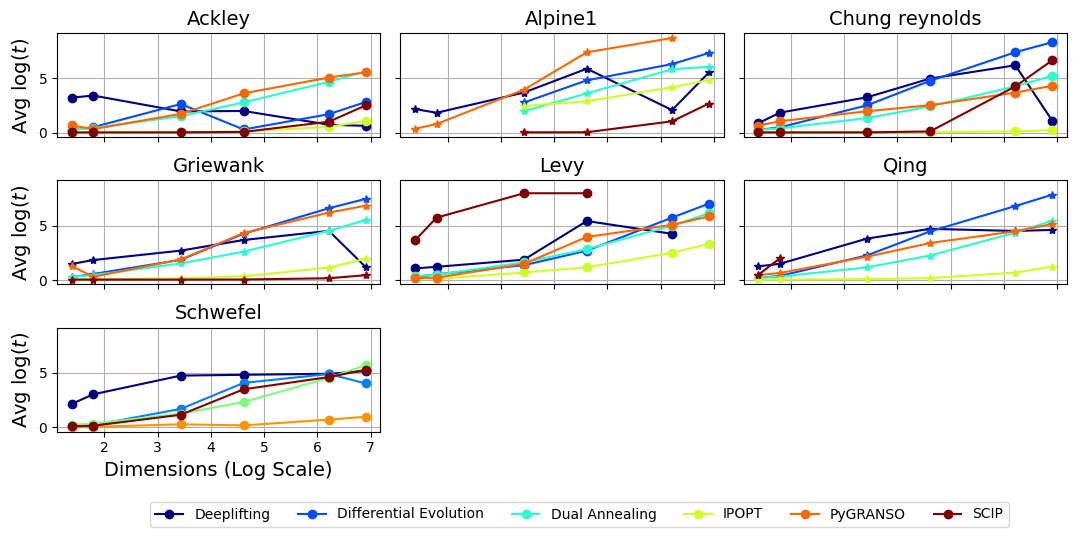

In [50]:
fig, axes = plt.subplots(3, 3, figsize=(11, 5), sharex=True, sharey=True)
axes = axes.flatten()
problems = results_df['problem'].unique().tolist()

lines = []
labels = []
markers = ['o', '*', 'o', '*', 'o', '*', 'o']
for index, problem in enumerate(problems):
    ax = axes[index]
    data = results_df.loc[results_df['problem'] == problem].reset_index(drop=True)
    data = data.pivot_table(
        index='dimensions-log', columns='algorithm', values='time-mean-log'
    )
    line = data.plot(ax=ax, cmap='jet', legend=False)
    ax.set_title(f'{problem.capitalize()}', fontsize=14)
    ax.grid()
    ax.set_xlabel('Dimensions (Log Scale)', fontsize=14)
    ax.set_ylabel('Avg $\log(t)$', fontsize=14)
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[index])

    if index == 0:
        lines, labels = ax.get_legend_handles_labels()

# Turn extra axis off
axes[7].axis('off')
axes[8].axis('off')

# # Create a single legend for all the plots
fig.legend(lines, labels, bbox_to_anchor=(0.94, 0.0), ncol=6)
fig.tight_layout()
fig.savefig(
    '/Users/ryandevera/data-science/umn_environments/Deeplifting/paper-images/high-dimension-time-vs-dim.png',
    bbox_inches='tight',
    pad_inches=0.01,
)

In [31]:
(
    results_df.loc[results_df['algorithm'] == 'Deeplifting']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      Deeplifting                                                  
dimensions            3         5         30        100       500       1000
problem                                                                     
Chung Reynolds    1.000000  1.000000  1.000000  1.000000  0.983333  1.000000
ackley            0.966667  0.733333  0.233333  0.183333  0.900000  1.000000
alpine1           1.000000  1.000000  0.383333  1.000000  0.000000  0.116667
griewank          0.016667  0.016667  0.616667  0.750000  0.660000  1.000000
levy              0.816667  0.616667  0.600000  0.150000  0.150000  0.000000
qing              1.000000  1.000000  0.966667  0.720000  0.000000  0.000000
schwefel          0.300000  0.066667  0.050000  0.000000  0.000000  0.000000

In [32]:
(
    results_df.loc[results_df['algorithm'] == 'Differential Evolution']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      Differential Evolution                         
dimensions                       3    5    30   100  500  1000
problem                                                       
Chung Reynolds                    1.0  1.0  1.0  1.0  0.7  0.0
ackley                            1.0  1.0  1.0  0.0  0.0  0.0
alpine1                           0.0  0.0  1.0  0.9  0.0  0.0
griewank                          0.6  0.0  0.4  0.9  0.1  0.0
levy                              1.0  1.0  0.1  0.0  0.0  0.0
qing                              1.0  1.0  1.0  1.0  0.0  0.0
schwefel                          0.8  0.1  0.0  0.0  0.0  0.0

In [33]:
(
    results_df.loc[results_df['algorithm'] == 'Dual Annealing']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      Dual Annealing                         
dimensions               3    5    30   100  500  1000
problem                                               
Chung Reynolds            1.0  1.0  1.0  1.0  1.0  1.0
ackley                    1.0  1.0  1.0  1.0  0.2  0.2
alpine1                   0.0  0.0  0.0  0.0  0.0  0.0
griewank                  0.0  0.0  0.7  1.0  0.7  0.1
levy                      1.0  1.0  1.0  1.0  1.0  1.0
qing                      1.0  1.0  1.0  1.0  0.4  0.2
schwefel                  1.0  1.0  1.0  1.0  0.9  0.2

In [34]:
(
    results_df.loc[results_df['algorithm'] == 'IPOPT']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      IPOPT                         
dimensions      3    5    30   100  500  1000
problem                                      
Chung Reynolds   1.0  1.0  0.1  0.3  0.2  0.0
ackley           0.0  0.0  0.0  0.0  0.0  0.0
alpine1          0.0  0.0  0.1  0.0  0.0  0.0
griewank         0.0  0.0  0.4  0.8  1.0  1.0
levy             0.1  0.0  0.0  0.0  0.0  0.0
qing             1.0  1.0  1.0  0.2  0.0  0.0
schwefel         0.1  0.0  0.0  0.0  0.0  0.0

In [36]:
(
    results_df.loc[results_df['algorithm'] == 'PyGRANSO']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      PyGRANSO                         
dimensions         3    5    30   100  500  1000
problem                                         
Chung Reynolds      1.0  1.0  1.0  1.0  1.0  1.0
ackley              0.0  0.0  0.0  0.0  0.0  0.0
alpine1             0.8  0.8  1.0  0.0  0.0  0.0
griewank            0.0  0.0  0.4  0.5  0.3  0.3
levy                0.0  0.0  0.0  0.0  0.0  0.0
qing                1.0  1.0  1.0  1.0  1.0  1.0
schwefel            0.1  0.1  0.0  0.0  0.0  0.0

In [45]:
(
    results_df.loc[results_df['algorithm'] == 'SCIP']
    .pivot_table(
        index='problem', columns=['algorithm', 'dimensions'], values='hits-mean'
    )
    .fillna(0.0)
)

algorithm      SCIP                         
dimensions     3    5    30   100  500  1000
problem                                     
Chung Reynolds  1.0  1.0  1.0  1.0  1.0  1.0
ackley          1.0  1.0  1.0  1.0  1.0  1.0
alpine1         0.0  0.0  1.0  1.0  1.0  1.0
griewank        1.0  1.0  1.0  1.0  1.0  1.0
levy            0.0  0.0  0.0  0.0  0.0  0.0
qing            1.0  1.0  0.0  0.0  0.0  0.0

In [43]:
(
    results_df.pivot_table(
        index=['problem', 'algorithm'], columns='dimensions', values='hits-mean'
    )
    .fillna(0.0)
    .mean(axis=1)
)

problem         algorithm             
Chung Reynolds  Deeplifting               0.997222
                Differential Evolution    0.783333
                Dual Annealing            1.000000
                IPOPT                     0.433333
                PyGRANSO                  1.000000
                SCIP                      1.000000
ackley          Deeplifting               0.669444
                Differential Evolution    0.500000
                Dual Annealing            0.733333
                IPOPT                     0.000000
                PyGRANSO                  0.000000
                SCIP                      1.000000
alpine1         Deeplifting               0.583333
                Differential Evolution    0.316667
                Dual Annealing            0.000000
                IPOPT                     0.016667
                PyGRANSO                  0.433333
                SCIP                      0.666667
griewank        Deeplifting               0